In [1]:
%pylab inline
import matplotlib.gridspec as gridspec
from astropy.table import Table,Column
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import os
from astropy.cosmology import WMAP9 
import requests
from scipy import stats
import matplotlib.patches as patches
import scipy.stats.distributions as dist
from scipy.optimize import curve_fit
from PIL import Image
import urllib, cStringIO
import random

#function for getting galaxy images
def get_image(url):
    file = cStringIO.StringIO(urllib.urlopen(url).read())
    img = Image.open(file)
    return img


mpl.rcParams['text.usetex']=True
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20 


Populating the interactive namespace from numpy and matplotlib


In [2]:
#ferengi data
data=Table.read('../new_ferengi/data/ferengi2_reduced.fits')

In [3]:
f_features =  't00_smooth_or_features_a1_features_frac_weighted_2'
#exclude edge-on disks
f_notedgeon = 't02_edgeon_a05_no_debiased'
n_edgeon = 't02_edgeon_a04_weight'
n_limit = (data[n_edgeon]<20)
f_limit = (data[n_edgeon]>=20) & (data[f_notedgeon]>=0.6)
data = data[n_limit | f_limit]
print '{} edge on disks excluded from data, leaving {} galaxies'.format(936-len(data),len(data))

134 edge on disks excluded from data, leaving 802 galaxies


In [8]:
def get_error(k,n,c=0.683):
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    return p_lower,p_upper

# calculate I, I_e, Ierr, I_e_err for different thresholds t

def get_I(t,morph_type):
    #t = thereshold for detecting disk galaxies 
    #morph_type = disks or elliptical 
    Inc = []
    Inc_lo = []
    Inc_hi = []
    yerr = []
    
    for zsim in range(3,11):
        f_at_3 = []
        f_at_z = []
        for gal in data: #for each galaxy at that redshift:
            f_at_3.append(gal['f_features_03']) #value of f_features at z=0.3
            f_at_z.append(gal['f_features_{:02d}'.format(zsim)]) #value of f_features at z=z
    
        f_at_3 = np.array(f_at_3)
        f_at_z = np.array(f_at_z)

        if morph_type == 'disk': #calculate number of disks 
            N_act = len(f_at_3[f_at_3>=t])
            N_obs = len(f_at_z[f_at_z>=t])
            I=float(N_obs)/N_act if (N_act+N_obs)>10  else 0
            Inc.append(I)
            errlo,errhi=get_error(N_obs,N_act,.95)
            Inc_lo.append(errlo)
            Inc_hi.append(errhi)

        
        else: #calculate number of ellipticals 
            N_act = len(f_at_3[f_at_3<t])
            N_obs = len(f_at_z[f_at_z<t])            
            I=float(N_obs)/N_act if (N_act+N_obs)>10  else 0
            Inc.append(I)
            errlo,errhi=get_error(N_act,N_obs,.95)
            Inc_lo.append(1./errlo)
            Inc_hi.append(1./errhi)    

        yerr.append(((errhi-I)+(I-errlo))/2) #average error for point
        
    #fit data to function, assume simple linear. feel free to try other functions. 
    def func(x, m, b):
        return m*x+b
    popt, pcov = curve_fit(func, zs, Inc, sigma=yerr)
    perr = np.sqrt(np.diag(pcov)) #error on slope, intercept of linear fit
    
    return Inc, Inc_hi, Inc_lo, popt, perr

In [5]:
zs= np.linspace(3,10,8)
zs = zs/10.
zs

array([ 0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [104]:
thresholds = [0.25,0.3]
# Save Incompletness values for diff. thresholds and errors
l = len(thresholds)
c0 = Column(data=np.zeros(l),name='threshold')
c1 = Column(data=np.zeros(l),name='slope') 
c2 = Column(data=np.zeros(l),name='intercept')
c3 = Column(data=np.zeros(l),name = 'slope_err')
c4 = Column(data=np.zeros(l),name = 'intercept_err')
c5 = Column(data=np.zeros(l),name='E_slope') 
c6 = Column(data=np.zeros(l),name='E_intercept')
c7 = Column(data=np.zeros(l),name = 'E_slope_err')
c8 = Column(data=np.zeros(l),name = 'E_intercept_err')


Inc_table = Table()  
Inc_table.add_columns([c0,c1,c2,c3,c4,c5,c6,c7,c8])



In [109]:
for i,t in enumerate(thresholds): 
    Inc_table['threshold'][i]=t
    Inc, Inc_hi, Inc_lo, popt, perr = get_I(t,'disk')
    Inc_table['slope'][i] = popt[0]
    Inc_table['intercept'][i]=popt[1]
    Inc_table['slope_err'][i]=perr[0]
    Inc_table['intercept_err'][i]=perr[1]
    Inc, Inc_hi, Inc_lo, popt, perr = get_I(t,'elliptical')
    Inc_table['E_slope'][i] = popt[0]
    Inc_table['E_intercept'][i]=popt[1]
    Inc_table['E_slope_err'][i]=perr[0]
    Inc_table['E_intercept_err'][i]=perr[1]

In [110]:
Inc_table

threshold,slope,intercept,slope_err,intercept_err,E_slope,E_intercept,E_slope_err,E_intercept_err
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.25,-0.469286714638,1.1397862307,0.0531316988255,0.0196808837046,0.196990691255,0.941349422399,0.0224690202579,0.00832546930179
0.3,-0.972074430269,1.28966655874,0.0415274228413,0.0150733207304,0.325076030193,0.903083683559,0.0152539126615,0.00534036542556


In [111]:
fname = '../data/ferengi_Inc.fits'
if os.path.exists(fname):
    os.remove(fname)
Inc_table.write(fname,format='fits')

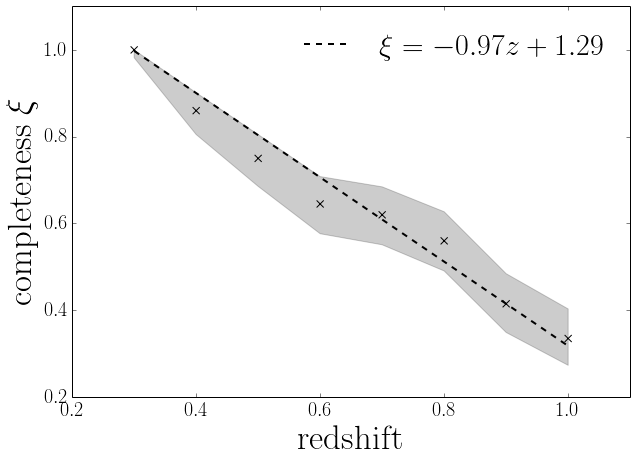

In [9]:
#plot stuff
t=0.3
Inc, Inc_hi, Inc_lo, popt, perr = get_I(t,'disk')
slope = popt[0]
intercept=popt[1]
f=plt.figure(figsize=(10,7))
plt.ylim(.2,1.1)
plt.xlim(.2,1.1)
plt.xlabel('$\mathrm{redshift}$',fontsize=35)
plt.ylabel(r'$\mathrm{completeness~\xi}$',fontsize=35)

plt.fill_between(zs,Inc_hi,Inc_lo,alpha=0.2,color='k')

plt.scatter(zs,Inc,marker='x',color='k',s=50)
plt.plot(zs,zs*slope+intercept,ls='dashed',c='k',label=r'$~\xi={:.2f}z+{:.2f}$'.format(slope,intercept),lw=2)
plt.legend(fontsize=30,frameon=False)

In [14]:
errhi = [a-b for a,b in zip(Inc_hi,Inc)]
errlo = [a-b for a,b in zip(Inc,Inc_lo)]

In [16]:
err = [(a+b)/2 for a,b in zip(errhi,errlo)]

In [17]:
err

[0.0090296493716082726,
 0.048099751731749629,
 0.059665333904062534,
 0.065805444380345413,
 0.06673393065612504,
 0.068220454474867215,
 0.067725143203711674,
 0.064924495576628383]

In [18]:
zs

array([ 0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])